# 분류 실습 - 캐글 신용카드 사기 검출

kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습

# 데이터 일차 가공 및 모델 학습/예측/평가

## 라이브러리 불러오기

In [1]:
# !pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] ='Malgun Gothic'
#plt.rcParams['font.family'] = 'AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] =False

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
import matplotlib.ticker as ticker

## 데이터 불러오기

In [2]:
df = pd.read_csv('./data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 데이터 확인

In [3]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

=> 레이블인 'Class' 속성은 매우 불균형한 분포를 갖고 있다

일반적으로 사기 검출이나 이상 검출과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포를 갖기 쉽다

    -> 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매주 적을 수밖에 없기 때문이다

### 언더 샘플링과 오버 샘플링

- 언더 샘플링

    - 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
    
    <br>
- 오버 샘플링

    - 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보
    
    - 동일한 데이터를 단순히 증식하면 과적합이 발생하므로 약간 변경하여 증식한다
    
    - SMOTE 방식은 이용 -> 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아 이 데이터와 K개 이웃들의 차이를 일정값으로 만들어 기존 데이텅와 약간 차이가 나는 새로운 데이터를 생성

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


=> V로 시작하는 feature의 의미를 알 수 없다.

=> 'Time' feature경우 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없으므로 제거

=> 'Amount' feature는 신용카드 트랜잭션 금액을 의미

## 데이터 가공

필요없는 col을 제거하는 get_preprocessed_df 함수 생성

In [5]:
# 인자로 입력받은 DataFrame을 복사한 뒤 'Time' col만 삭제후 복사된 DataFrame로 반환

def get_preprocessed_df(df = None):
    df_copy = df.copy() # df 복사
    df_copy.drop('Time', axis = 1, inplace = True) # 'Time' col 제거
    return df_copy

학습/테스트 데이터 세트를 return하는 get_train_test_dataset() 함수 생성

- 학습 feature/레이블 데이터 세트, 테스트 feature/레이블 데이터 세트를 반환

In [6]:
# 사전 데이터 가공 후 학습과 데이터 세트를 반환하는 함수

def get_train_test_dataset(df = None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame를 반환
    df_copy = get_preprocessed_df(df)
    
    # feature, 레이블 나누기
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지가 feature
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # 학습과 테스트 데이터 분할
    # stratify = y_target으로 stratified 기반으로 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('학습 데이터 feature shape : ',  X_train.shape)
print('학습 데이터 레이블 shape : ',  y_train.shape)

print('테스트 데이터 feature shape : ',  X_test.shape)
print('테스트 데이터 레이블 shape : ',  y_test.shape)

학습 데이터 feature shape :  (199364, 29)
학습 데이터 레이블 shape :  (199364,)
테스트 데이터 feature shape :  (85443, 29)
테스트 데이터 레이블 shape :  (85443,)


In [8]:
# 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)

print('\n테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


## 모델 학습/예측/평가

로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴보기

### 로지스틱

In [9]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred) # 혼동행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test , pred) # 재현율
    f1 = f1_score(y_test, pred) # f1 score
    roc_auc = roc_auc_score(y_test, pred_proba) # roc_auc
    
    score_df = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], columns = ['정확도', '정밀도', '재현율', 'F1', 'roc-auc'])
    
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return score_df

In [10]:
lr = LogisticRegression(max_iter = 1000) # 모델 생성, max_iter : 계산에 사용할 작업 수
lr.fit(X_train, y_train) # 학습
lr_pred = lr.predict(X_test) # 예측
lr_pred_proba = lr.predict_proba(X_test)[:, 1] # 확률 예측

# 평가 
lr_before_score = get_clf_eval(y_test, lr_pred, lr_pred_proba)

LogisticRegression(max_iter=1000)

오차행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, F1 : 0.7143, AUC : 0.9702


###  LightGBM

get_model_train_eval() 함수를 생성

인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트

In [11]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 합습/예측/평가 수행

def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None): # 학습 feature/레이블, 테스트 feature/레이블
    model.fit(ftr_train, tgt_train) # 학습
    pred = model.predict(ftr_test) # 예측
    pred_proba = model.predict_proba(ftr_test)[:, 1] # 확률 예측
    score_df = get_clf_eval(tgt_test, pred, pred_proba) # 평가
    
    return score_df

- 불균형한 레이블 값 분포도를 갖고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average = False로 파라미터 설정

- 레이블 값이 극도로 불균형한 분포인 데이터의 경우 boost_from_average = True(기본 값) 값은 재현율과 roc_auc_score를 매우 저하시킨다

In [12]:
lgbm_before = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1) # boost_from_average = True로 설정
get_model_train_eval(lgbm_before, X_train, X_test, y_train, y_test)

오차행렬
[[85223    72]
 [   64    84]]
정확도 : 0.9984, 정밀도 : 0.5385, 재현율 : 0.5676, F1 : 0.5526, AUC : 0.7866


,정확도,정밀도,재현율,F1,roc-auc
0,0.998408,0.538462,0.567568,0.552632,0.786617


In [13]:
lgbm = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False) # boost_from_average = False로 설정
lgbm_before_score = get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453, AUC : 0.9790


=> boost_from_average를 False로 설정했을 경우 roc-auc가 0.7626 -> 0.8783으로 높게 나왔다

=> lightGBM이 로지스틱(0.8040)보다 높게 나왔다

# 데이터 분포도 변환 후 모델 학습/예측평가

왜곡된 분포도를 가지는 데이터를 제가공한 뒤에 모델을 다시 테스트

## 중요 feature 값의 분포도 확인

'Amount' feature는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다

'Amount' feature의 분포도 확인

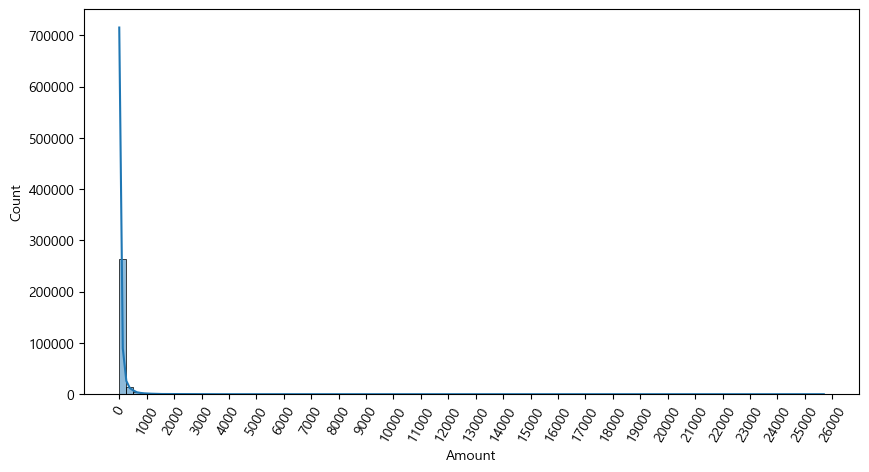

In [14]:
plt.figure(figsize = (10, 5));
plt.xticks(range(0, 30000, 1000), rotation = 60);
sns.histplot(df['Amount'], bins = 100, kde = True);

=> 카드 사용 금액이 1000불 이하인 데이터가 대부분

=> 26000불까지는 드물지만 많은 금액을 사용한 경우가 발생하면서 고리가 긴 형태의 분포 곡선을 띈다

=> 'Amount'를 표준 정규 분포 형태로 변환한 뒤 로지스틱 회귀의 예측 성능을 측정

## StandardScaler

### 데이터 가공

In [15]:
# 앞서 만든 get_preprocessed_df()함수 이용
# StandardScaler 클래스 이용해 정규 분포 형태로 'Amount' feature 변환하는 로직으로 수정
# StandardScaler : 변수 각각의 평균을 0, 분산을 1로 만든다

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    
    # scaler 생성
    scaler = StandardScaler()
    # fit : 데이터 변환을 위한 기존 정보 설정, transform : fit()을 통해 설정된 정보를 이용해 실제로 데이터를 변환
    amount_n = scaler.fit_transform(df_copy[['Amount']]) # 변경하고자 하는 데이터는 2차원 배열
    
    # 변환된 Amount를 Amount_Scaled로 feature명을 변경 후 DataFrame 맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존의 'Time', 'Amount' feature 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    
    return df_copy

get_train_test_dataset()을 호출해 학습/테스트 데이터 세트를 생성

In [16]:
# Amount를 정규 분포 형태로 변경

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('학습 데이터 feature shape : ',  X_train.shape)
print('학습 데이터 레이블 shape : ',  y_train.shape)

print('테스트 데이터 feature shape : ',  X_test.shape)
print('테스트 데이터 레이블 shape : ',  y_test.shape)

학습 데이터 feature shape :  (199364, 29)
학습 데이터 레이블 shape :  (199364,)
테스트 데이터 feature shape :  (85443, 29)
테스트 데이터 레이블 shape :  (85443,)


### 모델 학습/예측/평가

get_model_train_eval()을 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가

In [17]:
# 로지스틱
print('## 로지스틱 회귀 예측 성능 ##')
lr = LogisticRegression(max_iter = 1000)
lr_standard_score = get_model_train_eval(lr, X_train, X_test, y_train, y_test)

# LightGBM
print('\n## LightGBM ##')
lgbm = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
lgbm_standard_score = get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

## 로지스틱 회귀 예측 성능 ##
오차행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, F1 : 0.7143, AUC : 0.9702

## LightGBM ##
오차행렬
[[85290     5]
 [   37   111]]
정확도 : 0.9995, 정밀도 : 0.9569, 재현율 : 0.7500, F1 : 0.8409, AUC : 0.9779


## 로그 변환

로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법

### 데이터 가공

In [18]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n) # 로그 변환 데이터 추가
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True) # 필요없는 col 제거
    
    return df_copy

In [19]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

### 모델 학습/예측/평가

In [20]:
# 로지스틱
print('## 로지스틱 회귀 예측 성능 ##')
lr = LogisticRegression(max_iter = 1000)
lr_log_score = get_model_train_eval(lr, X_train, X_test, y_train, y_test)

# LightGBM
print('\n## LightGBM ##')
lgbm = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
lgbm_log_score = get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

## 로지스틱 회귀 예측 성능 ##
오차행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812, 재현율 : 0.6014, F1 : 0.7149, AUC : 0.9727

## LightGBM ##
오차행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635, F1 : 0.8496, AUC : 0.9796


=> 로지스틱 회귀인 경우 원본 데이터 대비 정밀도는 향상, 재현율은 저하

=> LightGBM인 경우 원본 데이터 대비 정밀도와 재현율이 향상

## 이상치 제거

DataFrame의 corr()를 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화

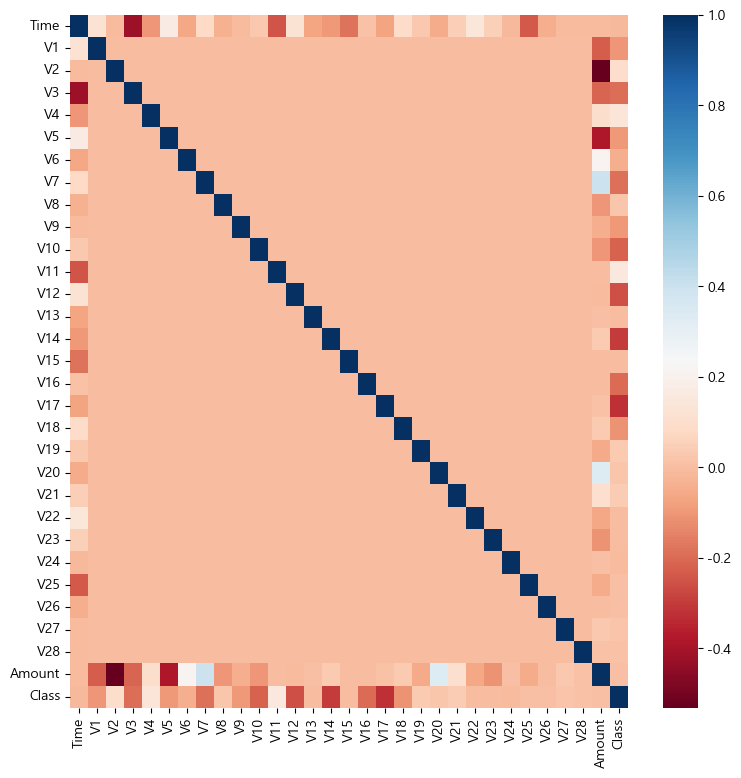

In [21]:
plt.figure(figsize = (9, 9));
corr = df.corr()
sns.heatmap(corr, cmap = 'RdBu');

### 데이터 가공

=> 양의 상관관계가 높을수록 색깔이 진한 파랑, 음의 상관관계가 높을수록 색깔이 진한 빨강

=> 'Class' feature와 음의 상관관계가 가장 높은 feature는 'V14', 'V17'이다

=> 'V14'에 대해서만 이상치를 찾아 제거

In [22]:
def get_outlier(df = None, column = None, weight = 1.5):
    
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 구함
    fraud = df[df['Class'] == 1][column]
    Q1 = fraud.quantile(0.25) # 1/4지점
    Q3 = fraud.quantile(0.75) # 3/4 지점
    
    # IQR 구하고 최댓값, 최솟값 지점 구하기
    IQR = Q3 - Q1
    IQR_weight = IQR * weight
    lowest_val = Q1 - IQR_weight
    highest_val = Q3 + IQR_weight
    
    # 최댓값돠 크거나, 최솟값보다 작은 값을 이상치로 판단
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [23]:
# get_outlier()함수를 이용해 'V14' col에서 이상치 데이터 찾기

outlier_index = get_outlier(df = df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Index([8296, 8615, 9035, 9252], dtype='int64')


In [24]:
# get_preprocessed_df()를 로그 변환 후 'V14' feature의 이상치 데이터를 삭제하는 로직으로 변경

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy

In [25]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

### 모델 학습/예측/평가

In [26]:
# 로지스틱
print('## 로지스틱 회귀 예측 성능 ##')
lr = LogisticRegression(max_iter = 1000)
lr_outlier_score = get_model_train_eval(lr, X_train, X_test, y_train, y_test)

# LightGBM
print('\n## LightGBM ##')
lgbm = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
lgbm_outlier_score = get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

## 로지스틱 회귀 예측 성능 ##
오차행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.6712, F1 : 0.7597, AUC : 0.9743

## LightGBM ##
오차행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9603, 재현율 : 0.8288, F1 : 0.8897, AUC : 0.9780


=> 이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측이 크게 향상

=> 로지스틱의 경우 재현율이 60.14%에서 67.12%로 증가

=> LightGBM의 경우 재현율이 76.35%에서 82.88%로 증가

## SMOTE

### 데이터 가공

In [27]:
smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 Class
0    199020
1    199020
Name: count, dtype: int64


### 모델 학습/예측/평가

생성된 학습 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델을 학습 한 뒤 성능 평가

In [28]:
lr = LogisticRegression(max_iter = 1000)

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over, y_train_over로 변경
lr_smote_score = get_model_train_eval(lr, X_train_over, X_test, y_train_over, y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율 : 0.9247, F1 : 0.1023, AUC : 0.9737


=> 이상치만 제거한 경우인 정밀도 87.50%에서 정밀도가 5.42%로 급격하게 저하

=> 로지스틱 회귀 몯레에 어떤 문제가 발생하는지 시각적으로 확인

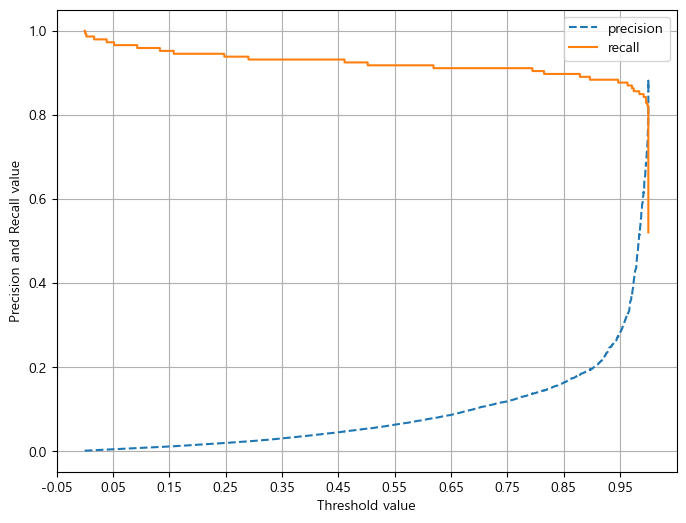

In [29]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 다른 정밀도, 재현율 ndarray 추출
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold값으로 y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')  
    
    # threhold 값 x축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    
precision_recall_curve_plot(y_test, lr.predict_proba(X_test)[:, 1])

=> 임계값이 0.99이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다

<br>

LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가 수행

In [30]:
lgbm = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
lgbm_smote_score = get_model_train_eval(lgbm, X_train_over, X_test, y_train_over, y_test)

오차행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118, 재현율 : 0.8493, F1 : 0.8794, AUC : 0.9814


=> LightGBM 모델에서 재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 나왔다

=> 정밀도는 이상치만 제거한 경우인 96.03%보다 낮은 91.18%가 나왔다

=> SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적이다

<br>

모델 별 평가지표 비교

In [31]:
lr_score = pd.concat([lr_before_score, lr_standard_score, lr_log_score, lr_outlier_score, lr_smote_score])
lr_score.index = [['lr_before_score', 'lr_standard_score', 'lr_log_score', 'lr_outlier_score', 'lr_smote_score']]

lgbm_score = pd.concat([lgbm_before_score, lgbm_standard_score, lgbm_log_score, lgbm_outlier_score, lgbm_smote_score])
lgbm_score.index = [['lgbm_before_score', 'lgbm_standard_score', 'lgbm_log_score', 'lgbm_outlier_score', 'lgbm_smote_score']]

tot_score = pd.concat([lr_score, lgbm_score])
tot_score.drop(['정확도', 'F1'], axis = 1, inplace = True)

tot_score

,정밀도,재현율,roc-auc
lr_before_score,0.865385,0.608108,0.970223
lr_standard_score,0.865385,0.608108,0.970227
lr_log_score,0.881188,0.601351,0.972683
lr_outlier_score,0.875000,0.671233,0.974272
lr_smote_score,0.054152,0.924658,0.973654
lgbm_before_score,0.957265,0.756757,0.979034
lgbm_standard_score,0.956897,0.750000,0.977872
lgbm_log_score,0.957627,0.763514,0.979624
lgbm_outlier_score,0.960317,0.828767,0.978002
lgbm_smote_score,0.911765,0.849315,0.981354


<Figure size 2000x2000 with 0 Axes>

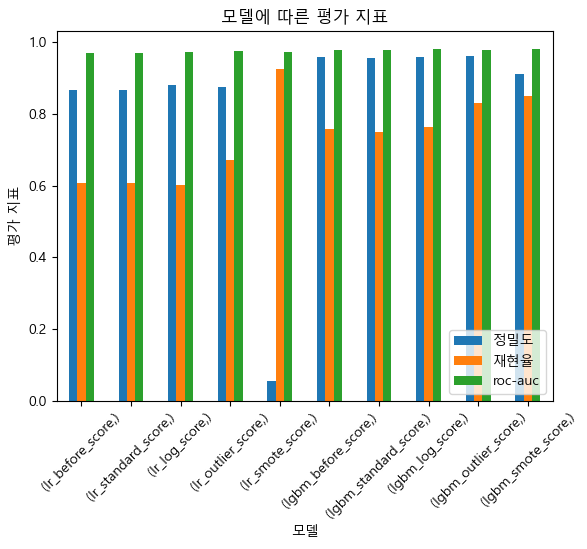

In [32]:
plt.figure(figsize = (20, 20));
tot_score.plot(kind = 'bar');
plt.legend(loc = 'lower right');
plt.ylabel('평가 지표');
plt.xlabel('모델');
plt.title('모델에 따른 평가 지표');
plt.xticks(rotation=45);